# **Data Augmentation for Image**

In [1]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape,x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
#reshape the data
x_train=x_train.reshape((x_train.shape[0],28,28,1))
x_test=x_test.reshape((x_test.shape[0],28,28,1))
# change the type to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [7]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

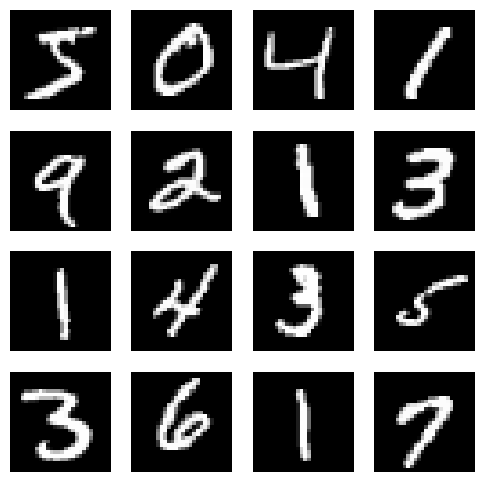

In [10]:
data_generator=ImageDataGenerator()
# configure batch for the images
for X_batch, y_batch in data_generator.flow(x_train, y_train, batch_size=16, shuffle=False):
    # create grid of 4x4 images
    fig, ax = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    break

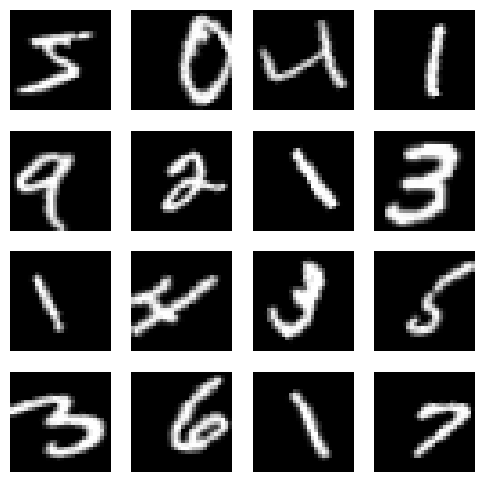

In [12]:
#data augmentation
data_generator=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2
)
# configure batch for the images
for X_batch, y_batch in data_generator.flow(x_train, y_train, batch_size=16, shuffle=False):
    # create grid of 4x4 images
    fig, ax = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    break

# **Transfer Learning using Pretrained Model**

In [1]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape,x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
# reshape the data
x_train = x_train.reshape((x_train.shape[0], 28, 28))
x_test = x_test.reshape((x_test.shape[0], 28, 28))
# change the type to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# convert data to 3 channels
x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



In [5]:
x_train.shape, x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [6]:
# data augmentation with generator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow(x_train, y_train, batch_size=512, shuffle=True)

val_iterator = val_generator.flow(x_test, y_test, batch_size=512, shuffle=False)

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
model = Sequential()
# add the pretrained model
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
# add fully connected layer with output
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# set resnet layers not trainable
model.layers[0].trainable=False
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 1054218 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [9]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch <= 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [11]:
lr = 0.01
for i in range(10):
    lr = scheduler(i, lr)
    print(i, lr)

0 0.01
1 0.01
2 0.01
3 0.01
4 tf.Tensor(0.009048373, shape=(), dtype=float32)
5 tf.Tensor(0.008187306, shape=(), dtype=float32)
6 tf.Tensor(0.0074081807, shape=(), dtype=float32)
7 tf.Tensor(0.006703199, shape=(), dtype=float32)
8 tf.Tensor(0.006065305, shape=(), dtype=float32)
9 tf.Tensor(0.0054881144, shape=(), dtype=float32)


In [12]:
callback = LearningRateScheduler(scheduler)

In [13]:
# train the model
model.fit(train_iterator, epochs=10, validation_data=val_iterator, callbacks=callback)

Epoch 1/10
118/118 [==============================] - 53s 341ms/step - loss: 1.4398 - accuracy: 0.5473 - val_loss: 0.7987 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 2/10
118/118 [==============================] - 40s 337ms/step - loss: 0.9190 - accuracy: 0.7185 - val_loss: 0.6063 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 3/10
118/118 [==============================] - 38s 319ms/step - loss: 0.7571 - accuracy: 0.7651 - val_loss: 0.5421 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 4/10
118/118 [==============================] - 36s 305ms/step - loss: 0.6839 - accuracy: 0.7844 - val_loss: 0.4830 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 5/10
118/118 [==============================] - 36s 305ms/step - loss: 0.6281 - accuracy: 0.8027 - val_loss: 0.4506 - val_accuracy: 0.8572 - lr: 9.0484e-04
Epoch 6/10
118/118 [==============================] - 38s 320ms/step - loss: 0.5882 - accuracy: 0.8151 - val_loss: 0.4463 - val_accuracy: 0.8576 - lr: 8.1873e-04
Epoch 7/10
118/118 [========================